<a href="https://colab.research.google.com/github/suirindo/Bird/blob/master/titanicVer_%E3%82%BB%E3%83%9F%E3%83%8A%E3%83%BC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参照URL

**codeExa**:

https://ct-innovation01.xyz/DL-Freetime/kaggle-003/

**趣味で始める機械学習**

https://ct-innovation01.xyz/DL-Freetime/kaggle-003/

**DeepAge**

https://deepage.net/features/pandas-describe.html

**csvファイルのデータのうち特定の値の個数をカウントする方法**

https://teratail.com/questions/170396



**KATUBLO | エンジニアの日常BLOG**
https://katuo-ai.com/2018/12/24/kaggle_titanic/#Cabin

# **事前準備**

## **タイタニック号のデータセットを準備**

1:下記2つのファイルをダウンロード。（https://www.kaggle.com/c/titanic/data）
[train.csv] [test.csv]

2:[titanic]と命名したフォルダに格納し、zip形式で圧縮する。[titanic.zip]となる。


3:[titanic.zip]をgoogle driveへアップロードする。


In [0]:
# 機械学習ライブラリのインポート
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as  np
import os
 
%matplotlib inline

In [0]:
#Googleドライブ 
import google.colab
import googleapiclient.discovery
import googleapiclient.http

In [0]:
#colabからgoogleDriveへの認証と接続
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [0]:
#colab環境でのファイルの取り込み
upload_filename = 'titanic.zip'

file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

#ファイルIDの取得
file_ID = None
for file in file_list:
  if file.get('name') == upload_filename:
    file_id = file.get('id')
    break

if file_id is None:
  #ファイルIDを取得できなかった場合はエラーメッセージを出力
  print(upload_filename + ' が見つかりません')
else:
  # colab環境へファイルをアップロードする
  with open(upload_filename, 'wb') as f:
    request = drive_service.files().get_media(fileId=file_id)
    media = googleapiclient.http.MediaIoBaseDownload(f, request)
    
    done = False
    while not done:
      progress_status, done = media.next_chunk()
      print(100*progress_status.progress(), end="")
      print("%完了")

print('GoogleドライブからColab環境へのファイル取り込みが完了')


100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了


In [0]:
#colab上にあるデータの確認
!ls

adc.json  sample_data  titanic.zip


In [0]:
#zipフォルダの解凍
!unzip titanic.zip

Archive:  titanic.zip
  inflating: titanic/test.csv        
  inflating: titanic/train.csv       


# **データの確認、探索的データ解析（EDA）**

EDA =　データの特徴を探求し、構造を理解すること。
機械学習（というより、統計を扱う上で）では重要なタスクの一つ

In [0]:
#データの読み込み


#訓練データの定義
train = pd.read_csv('./titanic/train.csv')
#テストデータの定義
test = pd.read_csv('./titanic/test.csv')
#データの確認（訓練データにどんなデータが入っているか）
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### **各項目の詳細説明**

PassengerId – 乗客識別ユニークID

Survived – 生存フラグ（0=死亡、1=生存）

Pclass – チケットクラス

Name – 乗客の名前

Sex – 性別（male=男性、female＝女性）

Age – 年齢

SibSp – タイタニックに同乗している兄弟/配偶者の数

parch – タイタニックに同乗している親/子供の数

ticket – チケット番号

fare – 料金

cabin – 客室番号

Embarked – 出港地（タイタニックへ乗った港）


**pclass = チケットクラス**

1 = 上層クラス（お金持ち）

2 = 中級クラス（一般階級）

3 = 下層クラス（労働階級）



**Embarked = 各変数の定義は下記の通り**

C = Cherbourg

Q = Queenstown

S = Southampton

In [0]:
#データの確認（テストデータにどんなデータが入っているか）
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
#データサイズの確認
train_shape = train.shape
test_shape = test.shape

print(train_shape)
print(test_shape)

(891, 12)
(418, 11)


In [0]:
#データの基本統計量の確認
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## **各項目の詳細説明**

count データの個数

mean 数値データの平均

std 数値データの標準偏差

min 最小値

max 最大値

25%,50%,75% 四分位数

(区切る部分はpercentiles引数で変更可能)

In [0]:
#データの基本統計量の確認
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## **`データの前処理`**
**＜欠損値の確認＞**


欠損がある箇所へ適切な値を代入して補う。

まずはデータに含まれる欠損値を確認する。

In [0]:
#欠損値の確認（train）
# null:値の何も入ってないセルを示す
def kesson_table(df): 
        null_val = df.isnull().sum()
        percent = 100 * df.isnull().sum()/len(df)
        kesson_table = pd.concat([null_val, percent], axis=1)
        kesson_table_ren_columns = kesson_table.rename(
        columns = {0 : '欠損数', 1 : '%'})
        return kesson_table_ren_columns
 
kesson_table(train)

,欠損数,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [0]:
#欠損値の確認（test）

def kesson_table(df): 
        null_val = df.isnull().sum()
        percent = 100 * df.isnull().sum()/len(df)
        kesson_table = pd.concat([null_val, percent], axis=1)
        kesson_table_ren_columns = kesson_table.rename(
        columns = {0 : '欠損数', 1 : '%'})
        return kesson_table_ren_columns
 
kesson_table(test)

,欠損数,%
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,86,20.574163
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.239234
Cabin,327,78.229665


**＜欠損値の補完 train＞**

欠損値に対して、適切な値を補完する。
今回は[Age] [Embarked]のみ対象とし、[Cabin]については取り上げない。

※欠損値が77％もあるため後ほど除外する。

### **Ageの対応**
データを可視化して対応策を検討する。

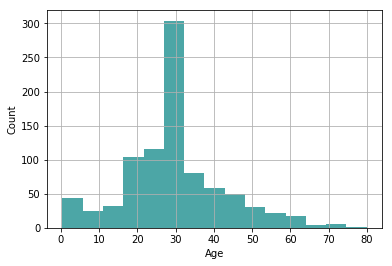

In [0]:
ax = train["Age"].hist(bins=15, color='teal', alpha=0.7)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

In [0]:
#欠損値へ適切な値を代入(train)

# Age median = 中央値を代入する
train['Age'].fillna(train['Age'].median(), inplace=True)

In [0]:
#[Embarked] 最も数の多い出港地を代表値とする。 
 
#各項目数の確認
print((train == 'S').sum().sum())
print((train == 'C').sum().sum())
print((train == 'Q').sum().sum())

644
168
77


/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


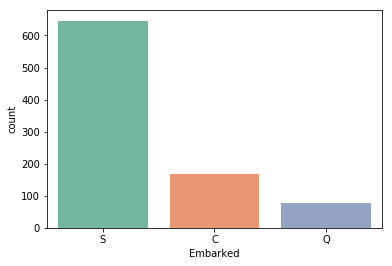

In [0]:
sns.countplot(x='Embarked',data=train,palette='Set2')
plt.show()

In [0]:
#上記から、Sを代入する
train['Embarked'].fillna('S', inplace=True)

In [0]:
# 欠損値補完の確認
kesson_table(train)

,欠損数,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


**＜欠損値の補完 test＞**

欠損値に対して、適切な値を補完する。
今回は[Age] [Fare]のみ対象とし、[Cabin]については取り上げない。

In [0]:
#欠損値へ適切な値を代入(train)

# Age median = 中央値を代入する
test["Age"] = test["Age"].fillna(test["Age"].median())

# Fare nullセルに、中央値を代入する。　※どうやってこの「１５２」を見つけたのか疑問
test.Fare[152] = test.Fare.median()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
# 欠損値補完の確認
kesson_table(test)

,欠損数,%
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000
Cabin,327,78.229665


# **ここまで（8.19）**

### **カテゴリ変数の数値化**

## **データの可視化**



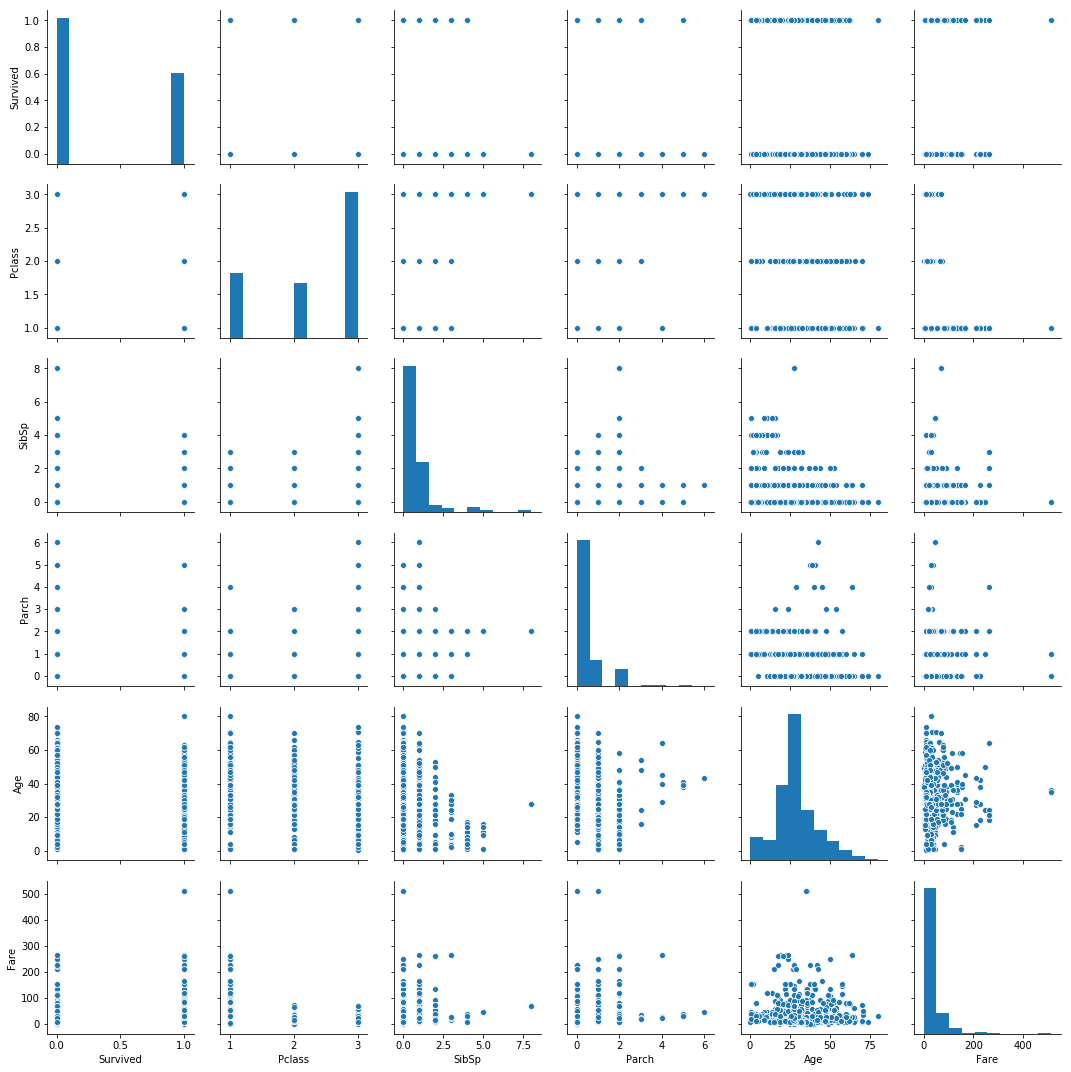

In [0]:
#データセットの各説明変数同士の相関を確認する

sns.pairplot(train[["Survived", "Pclass", "SibSp", "Parch", "Age", "Fare"]])
plt.show()

＜カテゴリデータの処理＞

文字列になっている値では、機械学習のアルゴリズムが適切な学習を行えない。

⇨アルゴリズムが学習しやすい適切な形に処理する。

PClass Sex を軸に、個々の乗客の生存率を可視化する

NameError: ignored

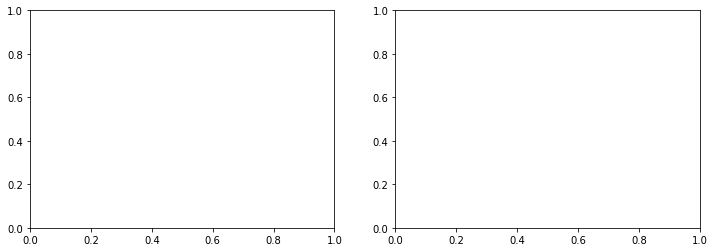

In [0]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# PClass
PClassPlot = train_set['Survived'].groupby(train_set['Pclass']).mean()
ax1.bar(x=PClassPlot.index, height=PClassPlot.values)
ax1.set_ylabel('Survival Rate')
ax1.set_xlabel('PClass')
ax1.set_xticks(PClassPlot.index)
ax1.set_yticks(np.arange(0, 1.1, .1))
ax1.set_title("Class and Survival Rate")

# Sex 
GenderPlot = train_set['Survived'].groupby(train_set['Sex']).mean()
ax2.bar(x=GenderPlot.index, height=GenderPlot.values)
ax2.set_ylabel('Survival Rate')
ax2.set_xlabel('Gender')
ax2.set_xticks(GenderPlot.index)
ax2.set_yticks(np.arange(0, 1.1, .1))
ax2.set_title("Class and Survival Rate")

In [0]:
'''
sibsp（同乗中の兄弟/配偶者の数）とparch（同乗中の親/子供の数）を軸に、個々の乗客乗員の生存率を出力するコード
'''

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Sibsp
SiblingPlot = train_set['Survived'].groupby(train_set['SibSp']).mean()
ax1.bar(x=SiblingPlot.index, height=SiblingPlot.values)
ax1.set_ylabel('Survival Rate')
ax1.set_xlabel('Total Siblings')
ax1.set_xticks(SiblingPlot.index)
ax1.set_yticks(np.arange(0, 1.1, .1))
ax1.set_title("Total Siblings and Survival Rate")

# Parch
ParchPlot = train_set['Survived'].groupby(train_set['Parch']).mean()
ax2.bar(x=ParchPlot.index, height=ParchPlot.values, width = .8, color = 'Teal')
ax2.set_ylabel('Survival Rate')
ax2.set_xlabel('Number of Parents and Childern abroad')
ax2.set_xticks(ParchPlot.index)
ax2.set_yticks(np.arange(0, 1.1, .1))
ax2.set_title("Number of Parents and Childern abroad and Survival Rate")


In [0]:
train_set['Sex'].head()

In [0]:
# Sex(性別)のカテゴリデータの処理　scikit-learn の labelencoder()を利用
labelencoder=LabelEncoder()
train_set['Sex'] = labelencoder.fit_transform(train_set['Sex'])

train_set['Sex'].head()

**EmbarkedとPclassをダミー変数へ変換するコード**

カテゴリをひとつ減らして処理しやすくする

In [0]:
# drop_first=True で、最初のカテゴリデータの値を意図的に落とす。
# Embarked （出発港）をダミー変数へ変換
Embarked = pd.get_dummies(train_set['Embarked'], drop_first=True)
Embarked.columns = ['Embarked-Q','Embarked-S']
Embarked.head()

In [0]:
# Pclass 
# Pclass （旅客等級）をダミー変数へ変換
Pclass = pd.get_dummies(train_set['Pclass'], drop_first=True)
Pclass.columns = ['PClass2','PClass3']
Pclass.head()

**特徴量エンジニアリング**

機械学習の予測精度向上のために、データに含まれている特徴量をもとに、新しい特徴量を追加する手法を指す。

タイタニック号データには、「性別」「旅客等級」など11個の特徴量が含まれている。これらをもとに特徴量を追加する。

**アイデア1:年齢の階級**
[Age]に入っている年齢を、4つに分類してみる。

4つに分けた年齢の階級ごとに、生存率が異なるかどうかを確認する。

⇨四分位数で分類。データを小さい順に並び替えた時に、データを4等分に区切った時の値を指す。

In [0]:
# Ageを４階級に区分
train_set['Age_Cat'] = pd.qcut(train_set['Age'],4)
AgePlot = train_set['Survived'].groupby(train_set['Age_Cat']).mean()
AgePlot


# 実行結果考察
'''
ラベルごとのターゲットの平均をmean()を使って算出した
28~35歳が、生存率が最も高い。
'''

**アイデア2:料金の階級**

In [0]:
# Fare を６階級に区分
train_set['Fare_Cat'] = pd.qcut(train_set['Fare'],6)
FarePlot = train_set['Survived'].groupby(train_set['Fare_Cat']).mean()
FarePlot

# 実行結果考察
'''
非常に顕著な傾向あり。
乗船料金が高ければ高いほど、生存確率が大幅に高まっていることがわかる。
'''

**アイデア3:同乗している家族の人数**

In [0]:
'''
sibspとparchの合計（乗員中の家族人数）
SibSp = 同乗中の兄弟/配偶者の数
Parch = 同乗中の親/子供の数
'''
train_set['Total Family'] = train_set['SibSp'] + train_set['Parch']
FamiliyPlot = train_set['Survived'].groupby(train_set['Total Family']).mean()
FamiliyPlot

# 実行結果考察
'''
同乗中の家族の人数も生存確率に影響していることがわかる。
最も生存確率の高い項目が[3名]であり、前後のデータの生存確率は大幅に下がっている。
'''

**アイデア4:単独乗船**

アイデア３の結果を受けてみて、乗船が単独のものであるかどうかも影響があるように思えることから検証実施。

「単独」と、「家族などと複数名で乗船」とを区別するクラスを特徴量として追加する。

単独:1

複数:0

In [0]:
# 単独乗船を定義
'''
乗船している家族の数が０＝単独乗船という条件　
この条件を満たせば1、満たさない場合は0がtrain_set['Alone]のカラムへ書き込まれる。
'''
train_set['Alone'] = np.where(train_set['Total Family']==0, 1, 0)
AlonePlot = train_set['Survived'].groupby(train_set['Alone']).mean()
AlonePlot

# 生存率＝単独での乗船<複数名

**アイデア5:名前の継承**

Nameには乗客乗員の文字列データが格納されており、名前に付随して「敬称」もデータとして入っている。

これらのデータから何か特徴が見えないか検証する。

In [0]:
# Name(名前)から敬称（title）を摘出
train_set['Title'] = train_set.Name.str.extract(r',\s*([^\.]*)\s*\.', expand=False)

In [0]:
# 上記、摘出したものをTitleとしてデータフレームに格納する。
train_set['Title'].unique()
# Pandasの

In [0]:
#これらの敬称の特色を考慮し、5つのグループに分類する。
#まずはリストでまとめる
Mr = ['Mr']
Crew1 = ['Don', 'Rev', 'Capt']
Crew2 = ['Major', 'Col', 'Dr']
Women_Masters = ['Mrs', 'Miss', 'Master']
Affluence = ['Mme', 'Ms', 'Lady', 'Sir', 'Mile', 'the Countess', 'Jonkheer']

In [0]:
'''
リスト
Name（名前）から摘出しTitle（敬称）をグループ分けして、Title_Groupとしてデータフレームへ追加する
'''
train_set['Title_Group'] = np.where(train_set['Title'] == Mr[0], 'Mr', 'Affluence')
train_set['Title_Group'] = np.where(train_set['Title'].isin(Crew1), 'Crew1', train_set['Title_Group'])
train_set['Title_Group'] = np.where(train_set['Title'].isin(Crew2), 'Crew2', train_set['Title_Group'])
train_set['Title_Group'] = np.where(train_set['Title'].isin(Women_Masters), 'Women_Masters', train_set['Title_Group'])
train_set['Title_Group'] = np.where(train_set['Title'].isin(Affluence), 'Affluence', train_set['Title_Group'])

In [0]:
#敬称の各グループのターゲットの平均値を表示
TitlePlot = train_set['Survived'].groupby(train_set['Title_Group']).mean()
TitlePlot



# 実行結果考察
"""
これまでのアイデアの中で、５の生存率が最も顕著に異なることがわかる。
"""

**「年齢の階級」と「料金の階級」の2つの新しい特徴量を訓練データへ追加する**

In [0]:
train_set['Age_Cat'] = pd.qcut(train_set['Age'],4,labels = ['Age Group1',
                                                            'Age Group2',
                                                            'Age Group3',
                                                            'Age Group4'])
train_set['Fare_Cat'] = pd.qcut(train_set['Fare'],6,labels = ['Fare Group1',
                                                            'Fare Group2',
                                                            'Fare Group3',
                                                            'Fare Group4',
                                                            'Fare Group5',
                                                            'Fare Group6'])

**train_set(訓練データ)に特徴量を追加する**

In [0]:
# Age,Fare,Title_Groupsをダミー変数へ変換

Age = pd.get_dummies(train_set['Age_Cat'], drop_first=True)
Fare = pd.get_dummies(train_set['Fare_Cat'], drop_first=True)
Title_Groups = pd.get_dummies(train_set['Title_Group'], drop_first=True)

#train_set へ全てのダミー変数を連結
train_set = pd.concat([train_set, Pclass, Embarked, Age, Fare, Title_Groups], axis=1)

#不要なカラムを訓練データから削除
train_set = train_set.drop(columns=['PassengerId', 'Pclass', 'Name', 'Fare', 'Embarked','Ticket', 'Cabin', 'Age', 'Age_Cat', 'Fare_Cat', 'Title', 'Title_Group','Crew1', 'Crew2', 'Mr', 'Women_Masters'])

#訓練データの全てのカラム（列）を表示
train_set.columns

**⬆️ここまでで、訓練データの前処理が全て完了**
※1:PClass2,PClass3  Embarked-S,Embarked-Q のタイトルがちゃんと出ていない
※2:2個ずつ出てる？

**訓練データを、特徴量XとターゲットYに切り分ける**

In [0]:
X_train = train_set.drop(columns='Survived')
y_train = train_set['Survived']

In [0]:
#テストデータ前処理のコード
# 欠損値の処理
test_set['Age'].fillna(test_set['Age'].median(), inplace=True)
test_set['Fare'].fillna(test_set['Fare'].median(), inplace=True)

# Sex(性別)の値を文字列から数値(0/1)へ変換
test_set['Sex'] = labelencoder.fit_transform(test_set['Sex'])

#PClass (旅客等級)とEmbarked (出発港)のダミー変数化
test_Pclass = pd.get_dummies(test_set['Pclass'],drop_first=True)
test_Pclass.columns =['PClass2','PClass3']
test_Embarked = pd.get_dummies(test_set['Embarked'],drop_first=True)
test_Embarked.columns = ['Embarked-Q','Embarked-S']

# 特徴量エンジニアリング
test_set['Age_Cat'] = pd.qcut(test_set['Age'],4)
Age_cat = pd.get_dummies(test_set['Age_Cat'], drop_first=True)
Age_cat.columns = ['Age Group 2','Age Group 3','Age Group 4']
test_set['Fare_Cat'] = pd.qcut(test_set['Fare'],6)
Fare_cat = pd.get_dummies(test_set['Fare_Cat'], drop_first=True)
Fare_cat.columns = ['Fare Group 2','Fare Group 3','Fare Group 4','Fare Group 5','Fare Group 6']
test_set['Total Family'] = test_set['SibSp'] + test_set['Parch']
test_set['Alone'] = np.where(test_set['Total Family']==0, 1, 0)
test_set['Title'] = test_set.Name.str.extract(r',¥s*([^¥.]*)¥s*¥.', expand=False)
test_set['Title_Group'] = np.where(test_set['Title'] == Mr[0], 'Mr','Affluence')
test_set['Title_Group'] = np.where(test_set['Title'].isin(Crew1), 'Crew1', test_set['Title_Group'])
test_set['Title_Group'] = np.where(test_set['Title'].isin(Crew2), 'Crew2', test_set['Title_Group'])
test_set['Title_Group'] = np.where(test_set['Title'].isin(Women_Masters), 'Women_Masters', test_set['Title_Group'])
test_set['Title_Group'] = np.where(test_set['Title'].isin(Affluence), 'Affluence', test_set['Title_Group'])
Title_Groups_test = pd.get_dummies(test_set['Title_Group'], drop_first=True)
test_set = pd.concat([test_set, test_Pclass,test_Embarked, Age_cat,Fare_cat, Title_Groups_test],axis=1)
PassengerID = test_set['PassengerId']
test_set = test_set.drop(columns=['Fare','Fare_Cat','Age_Cat','Age',
                                  'Name','Pclass','Ticket','Cabin',
                                  'PassengerId','Embarked','Title_Group','Title'])


In [0]:
test_set.columns

In [0]:
train_set.columns

# **機械学習モデルの交差検証**

・ロジスティック回帰

・サポートベクターマシン

・ランダムフォレスト


交差検証とは？

標本データの一部を先に解析し、残る部分でその解析をテストし、解析が妥当なものかを検証すること。

つまり、解析（シミュレーション）が本当に母集団に対処できるものなのかどうかを検証する手法のこと。


In [0]:
LR = LogisticRegression()
RF = RandomForestClassifier()
SVM = SVC()

In [0]:
#3つの学習モデルを構築して正解率を比較するコード

#交差検証のパラメータを設定
scores = []
modelnames = ['ロジスティック回帰', 'ランダムフォレスト', 'サポートベクターマシン']
models = [LR, RF, SVM]

#ループ処理で交差検証
#coss_val_score()に検証したい機械学習モデル、訓練データ（特徴量とターゲット）、検証をしたいスコア（scoring）と
#交差検証回数（cv）を渡す。今回は5回。その結果の平均をscoresのリストに追加する。

for i in models:
  score = cross_val_score(i, X_train, y_train, scoring = 'accuracy', cv = 5).mean()
  scores.append(score)

#結果を出力
pd.DataFrame(scores, index=modelnames,
             columns=['CV Scores']).sort_values(by = 'CV Scores', ascending=False)

#機械学習のアルゴリズムは学習の過程で乱数を用いる。そのため、正解率は毎回多少異なるものとなる。

今回は、svmが最も正解率の高い結果となった。

しかし上記の交差検証は、最初の取り掛かりに過ぎないため、より正しい判断を行うには各学習モデルの深い検証が必要となる。

# **Tips:ロジスティック回帰とは？**

教師あり学習の手法の1つで、最も初歩的なもの。

強み：確率的なアプローチが可能である。

生存率を「乗客Aは20%」「乗客Bは80%」といった値で返す。

分類のクラスに応じて確率的なアプローチを行う。

構造的にも非常にシンプルかつパワフルな手法である。


# **Tips:SVMとは？**

分類、回帰どちらでも利用可能であるが、一般的には分類で用いられることが多い。

境界線に近いデータを、「サポートベクター」と呼ぶ。

# **Tips:決定木とは？**

強み：構造がシンプルで、かつ推測結果を説明しやすい。頻繁に使われる。


In [0]:
#ランダムフォレストのモデル訓練
#訓練を行うメソッド「fit」へ、訓練データの特徴量を渡す。
#ランダムフォレストのハイパーパラメータが出力される。
RF.fit(X_train, y_train)

In [0]:
y_pred = RF.predict(test_set)

In [0]:
X_train.describe() 
"""
[X_train]と[test_set]で、特徴量の数が合わなかったためエラーが発生。
処置として、'Crew1', 'Crew2', 'Mr', 'Women_Masters'をX_trainから削除した。
"""

In [0]:
test_set.describe() 

In [0]:
my_solution = pd.DataFrame({'PassengerId' :PassengerID, 'Survived' :y_pred})
my_solution = my_solution.set_index('PassengerId')
my_solution.to_csv('submittitanic.csv')

In [0]:
from google.colab import files
  
files.download('submittitanic.csv')  

上記ファイルをkaggleに提出すると、正解率は77%だった。

以降、ハイパーパラメータチューニングとモデル評価を行うことで予測精度を改善する。

これまではscikit-learnのデフォルトのハイパーパラメータをそのまま使っていた。

ここからは、下記の5つのハイパーパラメータを交差検証して予測精度を向上させる。

bootstrap:訓練データの使われ方の設定を行うパラメータ（デフォルト＝True）

max_depth:ランダムフォレスト内の決定木の深さを設定するパラメータ

            ２層〜１００層までの設定を交差検証する。

min_samples_leaf:分岐し終わったノードの最小サンプル数を指定

min_samples_split:決定木が分岐する際に必要なサンプル数を指定

n_estimators:**最も重要。**

            ランダムフォレストで使用する決定木の本数を指定する。

ハイパーパラメータの調整には、

scikit-learnの[GridSearchCV]を使うと便利。

⇨あらかじめ調整したいハイパーパラメータと評価指標を指定することで、各値を用いたモデルを訓練して交差検証を実行してくれる。



In [0]:
#ランダムフォレストのハイパーパラメータを指定する
#GridSearchCVの設定
#交差検証したいハイパーパラメータの値をparam_gridとして辞書に格納する。
#続いて、GridSearchCVのクラスへ必要なパラメータを渡す。
param_grid = {'bootstrap' : [True],
              'max_depth' : [2,3,5,10,20,100],
              'min_samples_leaf' : [3,4,5],
              'min_samples_split' : [8,10,12],
              'n_estimators' : [100]}
#グリッドサーチ（評価＝正解率）
grid_searchlog = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy')


In [0]:
#最も正解率が高い値となるハイパーパラメータの組み合わせを算出
grid_searchlog.fit(X_train,y_train)
grid_searchlog.best_params_

In [0]:
optimated_rf = grid_searchlog.best_estimator_
y_pred_final = optimated_rf.predict(test_set)

In [0]:
my_solution = pd.DataFrame({'PassengerId' :PassengerID, 'Survived' :y_pred_final})
my_solution = my_solution.set_index('PassengerId')
my_solution.to_csv('submit_titanic_fin.csv')

In [0]:
from google.colab import files
  
files.download('submit_titanic_fin.csv')  

終了！